In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import CrostonOptimized, ADIDA, TSB

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
plt.rcParams["figure.figsize"] = (9,6)

In [6]:
df = pd.read_csv('data/intermittent_time_series.csv')

df.head()

,unique_id,ds,y
0,1,2023-01-01 00:00:00,43
1,1,2023-01-01 01:00:00,87
2,1,2023-01-01 02:00:00,89
3,1,2023-01-01 03:00:00,87
4,1,2023-01-01 04:00:00,73


In [7]:
models = [TSB(0.1, 0.1), ADIDA(), CrostonOptimized()]

sf = StatsForecast(
    df=df,
    models=models,
    freq='H',
    n_jobs=-1
)

cv_df = sf.cross_validation(
    df=df,
    h=1,
    step_size=1,
    n_windows=50
)

cv_df.index = np.arange(50, 100, 1)

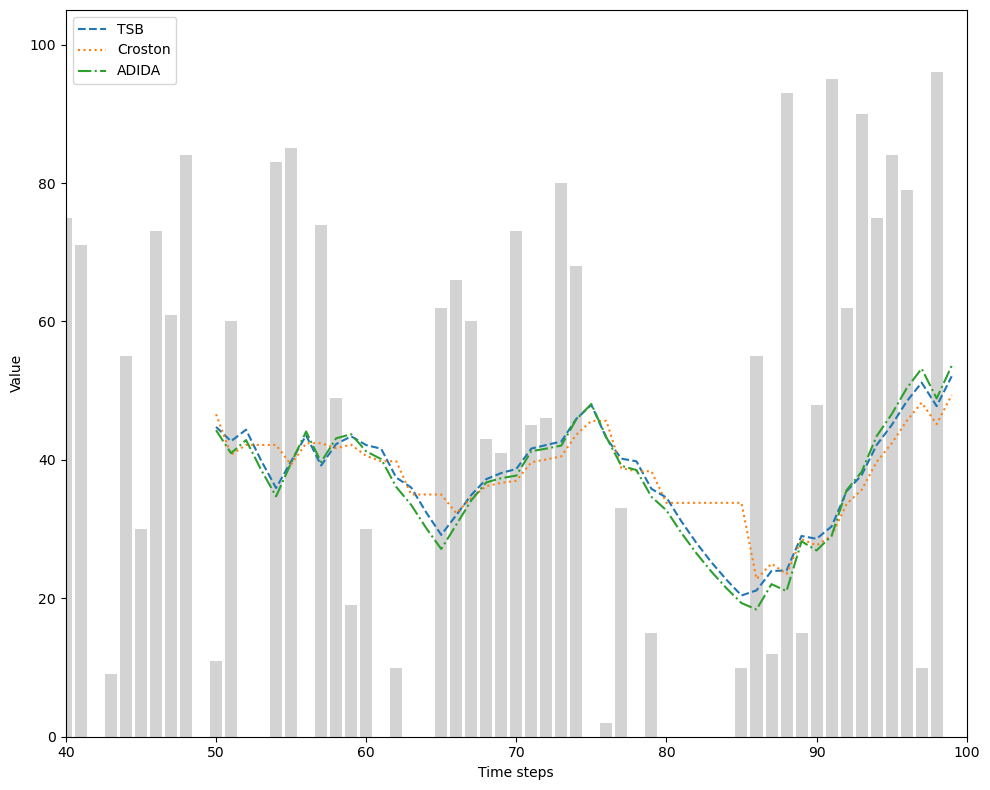

In [8]:
fig, ax = plt.subplots(figsize=(10,8))

ax.bar(df.index, df['y'], color='lightgray')
ax.plot(cv_df.index, cv_df['TSB'], ls='--', label='TSB')
ax.plot(cv_df.index, cv_df['CrostonOptimized'], ls=':', label='Croston')
ax.plot(cv_df.index, cv_df['ADIDA'], ls='-.', label='ADIDA')

ax.set_ylabel('Value')
ax.set_xlabel('Time steps')
ax.legend(loc='best')
plt.xlim(40, 100)

plt.tight_layout()

## CFE, CFE_min, CFE_max, PIS, NOS

In [32]:
def errors(y_true, y_pred):
    
    # CFE
    cfe_all = np.cumsum(y_true - y_pred)
    cfe = cfe_all.iloc[-1]
    
    cfe_max = np.max(cfe_all)
    cfe_min = np.min(cfe_all)
    
    # PIS
    pis_all = -np.cumsum(cfe_all)
    pis = pis_all.iloc[-1]
    
    # NOS
    nos = len(cfe_all[cfe_all > 0])

    errors = {
        "CFE": cfe,
        "CFE_max": cfe_max,
        "CFE_min": cfe_min,
        "PIS": pis,
        "NOS": nos
    }
    
    return errors

In [33]:
croston_errors = errors(cv_df['y'], cv_df['CrostonOptimized'])

In [34]:
croston_errors

{'CFE': -14.413212,
 'CFE_max': 34.96125411987305,
 'CFE_min': -332.0770568847656,
 'PIS': 5527.8726,
 'NOS': 3}

In [35]:
adida_errors = errors(cv_df['y'], cv_df['ADIDA'])
adida_errors

{'CFE': 39.358646,
 'CFE_max': 92.94744873046875,
 'CFE_min': -259.12799072265625,
 'PIS': 3711.2573,
 'NOS': 8}

In [36]:
tsb_errors = errors(cv_df['y'], cv_df['TSB'])
tsb_errors

{'CFE': 5.303444,
 'CFE_max': 57.37592315673828,
 'CFE_min': -291.7810363769531,
 'PIS': 4825.8857,
 'NOS': 6}

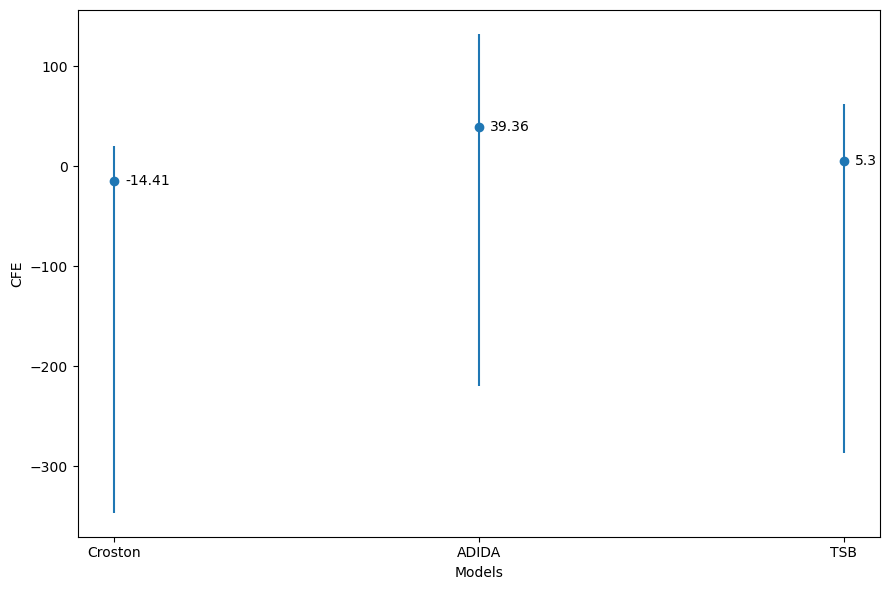

In [46]:
fig, ax = plt.subplots()

x = ['Croston', 'ADIDA', 'TSB']
y = [croston_errors['CFE'], adida_errors['CFE'], tsb_errors['CFE']]

errors = [
    [abs(croston_errors['CFE_min']), abs(adida_errors['CFE_min']), abs(tsb_errors['CFE_min'])],
    [croston_errors['CFE_max'], adida_errors['CFE_max'], tsb_errors['CFE_max']]
]

ax.errorbar(x, y, yerr=errors, fmt='o')
ax.set_xlabel('Models')
ax.set_ylabel('CFE')

for i, v in enumerate(y):
    plt.text(x=i+0.03, y=v, s=str(round(v,2)), va='center')

plt.tight_layout()

In [37]:
abs(-4)

4